# Weight errors

How much do estimated CCA and PLS weights vary across repetitions, depending on sample size?

## Setup

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.linalg
import scipy.stats
from scipy.stats import pearsonr, zscore
from scipy.spatial.distance import pdist, cdist, squareform

from sklearn import clone
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.utils import check_random_state

from gemmr.data import load_outcomes, print_ds_stats
from gemmr.generative_model import setup_model
from gemmr.sample_size import *
from gemmr.estimators import *
from gemmr.sample_analysis import *
from gemmr.plot import heatmap_n_req
from gemmr.util import nPerFtr2n
from gemmr.plot import polar_hist

import matplotlib
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.patheffects as path_effects
import holoviews as hv
from holoviews import opts
hv.extension('matplotlib')
hv.renderer('matplotlib').param.set_param(dpi=120)

from my_config import *

import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.simplefilter('ignore', MatplotlibDeprecationWarning)
warnings.filterwarnings(
    'ignore', 'aspect is not supported for Axes with xscale=log, yscale=linear', category=UserWarning
)  # holoviews emits this for log-linear plots

/Users/mdh56/Projects/gemmr_natcomm/gemmr/sample_analysis/analyzers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [2]:
import matplotlib
matplotlib.__version__

'3.1.3'

In [3]:
r_clrs = hv.Palette(cmap_r, samples=3).values
n_per_ftr_clrs = hv.Palette(cmap_n_per_ftr, samples=4).values
clr_random = 'darkslateblue'
clr_perm = 'gray'

## Analyze data with 100 features per set and a correlation 0.3

In [4]:
r_true = 0.3
px = 100

n_mul_cca = 10
res_cca_100 = analyze_model_parameters(
    'cca', 
    n_perm=0, 
    n_rep=100, 
    n_Sigmas=1, 
    n_test=0,#1000,
    pxs=[px], 
    py='px',
    n_per_ftrs=[n_per_ftr_typical, n_mul_cca*n_per_ftr_typical],
    rs=(r_true,), 
    powerlaw_decay=(-1, -1),
    random_state=0,
    qx=.9,
    qy=.9,
)


n_mul_pls = 10
res_pls_100 = analyze_model_parameters(
    'pls', 
    n_perm=0, 
    n_rep=100, 
    n_Sigmas=1, 
    n_test=0,#1000,
    pxs=[px], 
    py='px',
    n_per_ftrs=[n_per_ftr_typical, n_mul_pls*n_per_ftr_typical],
    rs=(r_true,), 
    powerlaw_decay=(-1, -1),
    random_state=0,
    qx=.9,
    qy=.9,
)

px:   0%|          | 0/1 [00:00<?, ?it/s]

r:   0%|          | 0/1 [00:00<?, ?it/s]

Sigma:   0%|          | 0/1 [00:00<?, ?it/s]

n_per_ftr:   0%|          | 0/2 [00:00<?, ?it/s]

repetition:   0%|          | 0/100 [00:00<?, ?it/s]

repetition:   0%|          | 0/100 [00:00<?, ?it/s]

px:   0%|          | 0/1 [00:00<?, ?it/s]

r:   0%|          | 0/1 [00:00<?, ?it/s]

Sigma:   0%|          | 0/1 [00:00<?, ?it/s]

n_per_ftr:   0%|          | 0/2 [00:00<?, ?it/s]

repetition:   0%|          | 0/100 [00:00<?, ?it/s]

repetition:   0%|          | 0/100 [00:00<?, ?it/s]

## Illustration of weight uncertainty

:Layout
   .Overlay.I  :Overlay
      .Area.N_reverse_over_mathrm_left_curly_bracket_typical_right_curly_bracket                      :Area   [Feature id]   (Weight,y2)
      .Area.10_reverse_over_cdot_n_reverse_over_mathrm_left_curly_bracket_typical_right_curly_bracket :Area   [Feature id]   (Weight,y2)
      .Curve.True                                                                                     :Curve   [Feature id]   (Weight)
      .HLine.I                                                                                        :HLine   [Feature id,Weight]
   .Overlay.II :Overlay
      .Area.N_reverse_over_mathrm_left_curly_bracket_typical_right_curly_bracket                      :Area   [Feature id]   (Weight,y2)
      .Area.10_reverse_over_cdot_n_reverse_over_mathrm_left_curly_bracket_typical_right_curly_bracket :Area   [Feature id]   (Weight,y2)
      .Curve.True                                                                                     :Curve   [Feature id]   (Weight)
      .HLine.I                                                                                        :HLine   [Feature id,Weight]
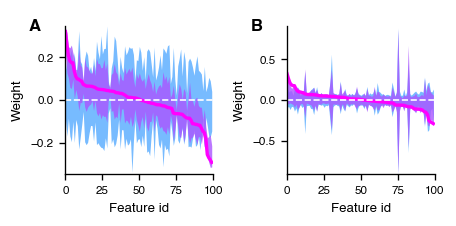

In [5]:
panels_weights_100 = dict()

qs = (.025, .975)

for model, res, n_mul, n_mul_clr in [
    ('cca', res_cca_100, n_mul_cca, n_per_ftr_clrs[1]), 
    ('pls', res_pls_100, n_mul_pls, n_per_ftr_clrs[2])
]:

    _res = res.sel(mode=0, Sigma_id=0, px=px, r=0.3)
    _w_true = _res.x_weights_true
    w_true = _w_true.sortby(_w_true, ascending=False)
    w_q = _res.x_weights.quantile(qs, 'rep').sortby(_w_true, ascending=False)
    
    panels_weights_100[model] = (
        hv.Area(
            (np.arange(len(w_true)), 
             w_q.sel(n_per_ftr=n_per_ftr_typical, quantile=qs[0]).values, 
             w_q.sel(n_per_ftr=n_per_ftr_typical, quantile=qs[-1]).values),
            vdims=['y', 'y2'],
            label='$n_\mathrm{typical}$'
        ).opts(color=n_per_ftr_clrs[1])
        * hv.Area(
            (np.arange(len(w_true)), 
             w_q.sel(n_per_ftr=n_mul*n_per_ftr_typical, quantile=qs[0]).values, 
             w_q.sel(n_per_ftr=n_mul*n_per_ftr_typical, quantile=qs[-1]).values),
            vdims=['y', 'y2'],
            label='$%i\cdot n_\mathrm{typical}$' % n_mul
        ).opts(color=n_per_ftr_clrs[2])
        * hv.Curve(w_true.values, label='true').opts(color=n_per_ftr_clrs[-1])
        * hv.HLine(0).opts(color='white', linestyle='--', linewidth=1)
    ).redim(
        x='Feature id',
        y='Weight'
    ).opts(
        opts.Area(alpha=.8, linewidth=0, show_legend=False),
        opts.Curve(show_legend=False),
        opts.Overlay(xlim=(0, 100), ylim=(-np.abs(w_q).max(), np.abs(w_q).max()))
    )
    
(
    panels_weights_100['cca']
    + panels_weights_100['pls']
).opts(*fig_opts)

### Sample size dependence

In [7]:
n_mul_pls = 10
res_pls_100_ = analyze_model_parameters(
    'pls', 
    n_perm=0, 
    n_rep=100, 
    n_Sigmas=1, 
    n_test=0,#1000,
    pxs=[px], 
    py='px',
    n_per_ftrs=[n_per_ftr_typical, n_mul_pls*n_per_ftr_typical, 150],
    rs=(r_true,), 
    powerlaw_decay=(-1, -1),
    random_state=0,
    qx=.9,
    qy=.9,
)

px:   0%|          | 0/1 [00:00<?, ?it/s]

r:   0%|          | 0/1 [00:00<?, ?it/s]

Sigma:   0%|          | 0/1 [00:00<?, ?it/s]

n_per_ftr:   0%|          | 0/3 [00:00<?, ?it/s]

repetition:   0%|          | 0/100 [00:00<?, ?it/s]

repetition:   0%|          | 0/100 [00:00<?, ?it/s]

repetition:   0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
res_pls_100__ = res_pls_100_.sel(px=100, r=r_true, Sigma_id=0, mode=0)

In [9]:
delta_xw = res_pls_100__.x_weights.mean('rep') - res_pls_100__.x_weights_true

:Overlay
   .Curve.A_5_smpls_over_ftr   :Curve   [Principal component]   ($X$ Weight - true $X$ weight)
   .Curve.A_50_smpls_over_ftr  :Curve   [Principal component]   ($X$ Weight - true $X$ weight)
   .Curve.A_150_smpls_over_ftr :Curve   [Principal component]   ($X$ Weight - true $X$ weight)
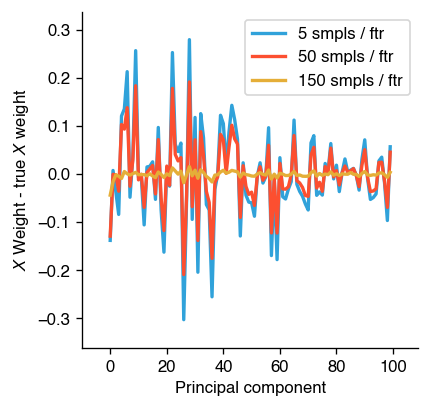

In [10]:
(
    hv.Curve(delta_xw.sel(n_per_ftr=5), label='5 smpls / ftr') 
    * hv.Curve(delta_xw.sel(n_per_ftr=50), label='50 smpls / ftr') 
    * hv.Curve(delta_xw.sel(n_per_ftr=150), label='150 smpls / ftr')
).redim(
    x_feature='Principal component',
    y='$X$ Weight - true $X$ weight'
).opts(padding=.1)

## How many samples are required to obtain at most 10% weight error?

In [11]:
ds_cca = load_outcomes('sweep_cca_cca_random_sum+-2+-2').sel(mode=0)
ds_pls = load_outcomes('sweep_pls_pls_random_sum+-2+-2').sel(mode=0)

In [12]:
ds_cca = ds_cca.sel(px=ds_cca.px<128)
ds_pls = ds_pls.sel(px=ds_pls.px<128)

In [13]:
print_ds_stats(ds_cca)

n_rep		 100
n_per_ftr	 [   3    4    8   16   32   64  128  256  512 1024 2048 4096 8192]
r		 [0.1 0.3 0.5 0.7 0.9]
px		 [ 2  4  8 16 32 64]
ax+ay range	(-2.00, -2.00)
py		== px

<xarray.DataArray 'n_Sigmas' (px: 6, r: 5)>
array([[25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25],
       [ 0, 25, 25, 25, 25]])
Coordinates:
  * r        (r) float64 0.1 0.3 0.5 0.7 0.9
  * px       (px) int64 2 4 8 16 32 64

power		calculated


In [14]:
print_ds_stats(ds_pls)

n_rep		 100
n_per_ftr	 [   3    4    8   16   32   64  128  256  512 1024 2048 4096 8192]
r		 [0.1 0.3 0.5 0.7 0.9]
px		 [ 2  4  8 16 32 64]
ax+ay range	(-2.00, -2.00)
py		== px

<xarray.DataArray 'n_Sigmas' (px: 6, r: 5)>
array([[25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25],
       [ 0, 25, 25, 25, 25],
       [ 0, 25, 25, 25, 25],
       [ 0,  0,  0, 25, 25]])
Coordinates:
  * r        (r) float64 0.1 0.3 0.5 0.7 0.9
  * px       (px) int64 2 4 8 16 32 64

power		calculated


In [15]:
cca_n_req_per_ftr = calc_n_required_all_metrics(ds_cca, search_dim='n_per_ftr')
pls_n_req_per_ftr = calc_n_required_all_metrics(ds_pls, search_dim='n_per_ftr')

:Layout
   .QuadMesh.Weight_error_reverse_over_leq_10_percent.I  :QuadMesh   [Number of features,$r_\mathrm{true}$]   (Required sample size)
   .QuadMesh.Weight_error_reverse_over_leq_10_percent.II :QuadMesh   [Number of features,$r_\mathrm{true}$]   (Required sample size)
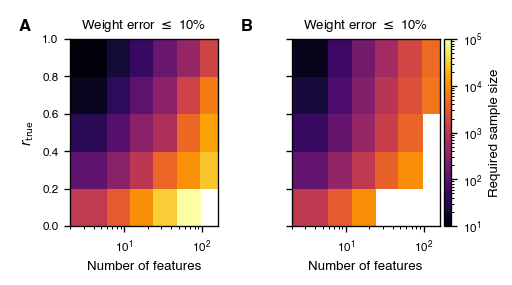

In [16]:
fig_required_sample_size_heatmap = (
    heatmap_n_req(nPerFtr2n(cca_n_req_per_ftr['weightError'], ds_cca.py)).relabel('Weight error $\leq$ 10%')
    + heatmap_n_req(nPerFtr2n(pls_n_req_per_ftr['weightError'], ds_pls.py)).relabel('Weight error $\leq$ 10%').opts(colorbar=True, yaxis='bare')
).cols(
    2
).opts(*fig_opts).opts(
    opts.QuadMesh(logx=True, logz=True, ylim=(0, 1), #xlim=(2, 256+64)
                  clim=(1e1, 1e5), cmap='inferno',
                  sublabel_position=(-.45, .95),
                  fontsize=dict(labels=8, ticks=7, legend=7, title=8),
                 ),
    #opts.Overlay(),
    opts.Layout(fig_inches=(3.42, None))
)

fig_required_sample_size_heatmap

## How similar are estimated CCA and PLS weights across repetitions?

In [17]:
res_cossim_weights = dict(
    #cca=load_outcomes('cca', tag='cossimWeightStats').sel(mode=0),
    cca=load_outcomes('weightStability_cca_cca_random_sum+-2+-2').sel(mode=0),
    pls=load_outcomes('weightStability_pls_pls_random_sum+-2+-2').sel(mode=0),
)

What's in the outcome data files?

In [18]:
print_ds_stats(res_cossim_weights['cca'])

n_rep		 100
n_per_ftr	 [  3   8  16  32  64 128 256 512]
r		 [0.3]
px		 [100]
ax+ay range	(-2.00, -2.00)
py		== px

<xarray.DataArray 'n_Sigmas' (px: 1, r: 1)>
array([[100]])
Coordinates:
  * r        (r) float64 0.3
  * px       (px) int64 100

power		not calculated


In [19]:
print_ds_stats(res_cossim_weights['pls'])

n_rep		 100
n_per_ftr	 [  3   8  16  32  64 128 256 512]
r		 [0.3]
px		 [100]
ax+ay range	(-2.00, -2.00)
py		== px

<xarray.DataArray 'n_Sigmas' (px: 1, r: 1)>
array([[100]])
Coordinates:
  * r        (r) float64 0.3
  * px       (px) int64 100

power		not calculated


In [20]:
def plot_cossim_weights_stats(res, outcome='x_weights_pairwise_cossim_stats', color=None):
    
    stats = res[outcome]
    ptot = res.px + res.py
    
    panel = hv.Overlay()
    for i in stats.Sigma_id.values:
        panel *= hv.Curve(
            (stats.n_per_ftr, stats.sel(stat='mean', Sigma_id=i))
        ).opts(linewidth=1, linestyle='--', alpha=.1)
    
    panel *= (
        #hv.Area(
        #    (stats.n_per_ftr * ptot, stats.sel(stat='q2.5%'), stats.sel(stat='q97.5%')),
        #    vdims=['y', 'y2']
        #)
        hv.Curve(
            (stats.n_per_ftr, stats.sel(stat='mean').mean('Sigma_id'))
        )
    )
    
    return panel.redim(
        x='Samples per feature',
        y='Weight stability'
    ).opts(
        opts.Area(alpha=.33, color=color),
        opts.Curve(color=color),
        opts.Overlay(ylim=(0, 1), logx=True)
    )

:Layout
   .Overlay.I  :Overlay
      .Curve.I        :Curve   [Samples per feature]   (Weight stability)
      .Curve.II       :Curve   [Samples per feature]   (Weight stability)
      .Curve.III      :Curve   [Samples per feature]   (Weight stability)
      .Curve.IV       :Curve   [Samples per feature]   (Weight stability)
      .Curve.V        :Curve   [Samples per feature]   (Weight stability)
      .Curve.VI       :Curve   [Samples per feature]   (Weight stability)
      .Curve.VII      :Curve   [Samples per feature]   (Weight stability)
      .Curve.VIII     :Curve   [Samples per feature]   (Weight stability)
      .Curve.IX       :Curve   [Samples per feature]   (Weight stability)
      .Curve.X        :Curve   [Samples per feature]   (Weight stability)
      .Curve.XI       :Curve   [Samples per feature]   (Weight stability)
      .Curve.XII      :Curve   [Samples per feature]   (Weight stability)
      .Curve.XIII     :Curve   [Samples per feature]   (Weight stability)
      .Curve.XIV      :Curve   [Samples per feature]   (Weight stability)
      .Curve.XV       :Curve   [Samples per feature]   (Weight stability)
      .Curve.XVI      :Curve   [Samples per feature]   (Weight stability)
      .Curve.XVII     :Curve   [Samples per feature]   (Weight stability)
      .Curve.XVIII    :Curve   [Samples per feature]   (Weight stability)
      .Curve.XIX      :Curve   [Samples per feature]   (Weight stability)
      .Curve.XX       :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXI      :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXII     :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXIII    :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXIV     :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXV      :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXVI     :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXVII    :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXVIII   :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXIX     :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXX      :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXXI     :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXXII    :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXXIII   :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXXIV    :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXXV     :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXXVI    :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXXVII   :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXXVIII  :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXXIX    :Curve   [Samples per feature]   (Weight stability)
      .Curve.XL       :Curve   [Samples per feature]   (Weight stability)
      .Curve.XLI      :Curve   [Samples per feature]   (Weight stability)
      .Curve.XLII     :Curve   [Samples per feature]   (Weight stability)
      .Curve.XLIII    :Curve   [Samples per feature]   (Weight stability)
      .Curve.XLIV     :Curve   [Samples per feature]   (Weight stability)
      .Curve.XLV      :Curve   [Samples per feature]   (Weight stability)
      .Curve.XLVI     :Curve   [Samples per feature]   (Weight stability)
      .Curve.XLVII    :Curve   [Samples per feature]   (Weight stability)
      .Curve.XLVIII   :Curve   [Samples per feature]   (Weight stability)
      .Curve.XLIX     :Curve   [Samples per feature]   (Weight stability)
      .Curve.L        :Curve   [Samples per feature]   (Weight stability)
      .Curve.LI       :Curve   [Samples per feature]   (Weight stability)
      .Curve.LII      :Curve   [Samples per feature]   (Weight stability)
      .Curve.LIII     :Curve   [Samples per feature]   (Weight stability)
      .Curve.LIV      :Curve   [Samples per fe
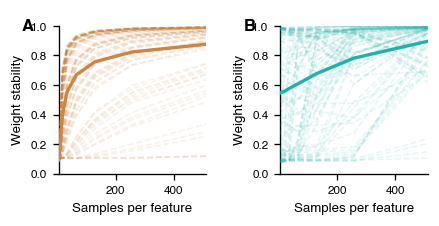

In [21]:
(
    plot_cossim_weights_stats(res_cossim_weights['cca'].sel(px=100, r=0.3), color=clr_cca) 
    + (
        plot_cossim_weights_stats(res_cossim_weights['pls'].sel(px=100, r=0.3), color=clr_pls)
        #* hv.Text(700, .6, 'mean', halign='left', valign='top', fontsize=8)
        #* hv.Text(5500, .3, '1 cov\nmatrix', halign='right', valign='bottom', fontsize=8)
    )
).opts(*fig_opts).opts(
    opts.Overlay(logx=False)
)

## 2 features

First, we look into a toy example where both datasets have only 2 features. In this case, weight vectors are two-dimensional unit vectors and can therefore be illustrated as points on a circle.

In [22]:
n_rep = 10000
random_state = 17

ds_cca_2 = analyze_model_parameters(
    'cca',
    pxs=[2],
    py='px',
    n_per_ftrs=[n_per_ftr_typical, 10*n_per_ftr_typical],
    rs=[.3],
    powerlaw_decay=(-1, -1),
    n_Sigmas=1,
    n_rep=n_rep,
    random_state=random_state
)

ds_pls_2 = analyze_model_parameters(
    'pls',
    pxs=[2],
    py='px',
    n_per_ftrs=[n_per_ftr_typical, 10*n_per_ftr_typical],
    rs=[.3],
    powerlaw_decay=(-1, -1),
    n_Sigmas=1,
    n_rep=n_rep,
    random_state=random_state
)

dss_2 = dict(cca=ds_cca_2, pls=ds_pls_2)

px:   0%|          | 0/1 [00:00<?, ?it/s]

r:   0%|          | 0/1 [00:00<?, ?it/s]

Sigma:   0%|          | 0/1 [00:00<?, ?it/s]

n_per_ftr:   0%|          | 0/2 [00:00<?, ?it/s]

repetition:   0%|          | 0/10000 [00:00<?, ?it/s]

repetition:   0%|          | 0/10000 [00:00<?, ?it/s]

px:   0%|          | 0/1 [00:00<?, ?it/s]

r:   0%|          | 0/1 [00:00<?, ?it/s]

Sigma:   0%|          | 0/1 [00:00<?, ?it/s]

n_per_ftr:   0%|          | 0/2 [00:00<?, ?it/s]

repetition:   0%|          | 0/10000 [00:00<?, ?it/s]

repetition:   0%|          | 0/10000 [00:00<?, ?it/s]

In [23]:
def calc_angles(da):
    return xr.apply_ufunc(
        lambda x: np.arctan(x[1] / x[0]) + np.pi/2,
        da,
        input_core_dims=[['x_feature']],
        vectorize=True
    )


def directional_mean(angles):
    R = np.exp(2j*angles).mean()
    mn = np.angle(R) / 2#np.arctan(R.imag / R.real)# / 2
    if mn < 0:
        mn = np.pi + mn
    return mn

:Layout
   .Overlay.I  :Overlay
      .VLine.I    :VLine   [r_hist,angle_hist]
      .Text.I     :Text   [r_hist,angle_hist]
      .Curve.I    :Curve   [theta]   (r)
      .Scatter.I  :Scatter   [r_hist]   (angle_hist)
      .Curve.II   :Curve   [theta]   (r)
      .Scatter.II :Scatter   [r_hist]   (angle_hist)
      .Text.II    :Text   [r_hist,angle_hist]
      .VLine.II   :VLine   [r_hist,angle_hist]
      .Text.III   :Text   [r_hist,angle_hist]
      .Text.IV    :Text   [r_hist,angle_hist]
   .Overlay.II :Overlay
      .VLine.I    :VLine   [r_hist,angle_hist]
      .Text.I     :Text   [r_hist,angle_hist]
      .Curve.I    :Curve   [theta]   (r)
      .Scatter.I  :Scatter   [r_hist]   (angle_hist)
      .Curve.II   :Curve   [theta]   (r)
      .Scatter.II :Scatter   [r_hist]   (angle_hist)
      .Text.II    :Text   [r_hist,angle_hist]
      .VLine.II   :VLine   [r_hist,angle_hist]
      .Text.III   :Text   [r_hist,angle_hist]
      .Text.IV    :Text   [r_hist,angle_hist]
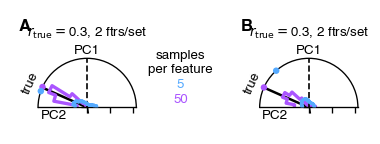

In [24]:
thetas = np.linspace(0, np.pi, 18)
panels_weights_2 = dict(cca=hv.Overlay(), pls=hv.Overlay())


def samples_per_feature_legend(plot, element):
    ax = plot.handles['axis']
    kwargs = dict(ha='center', fontsize=8, transform=ax.transAxes)
    ax.text(1.45, .6, 'samples\nper feature', color='black', **kwargs)
    ax.text(1.45, .3, '50', color=n_per_ftr_clrs[2], **kwargs)
    ax.text(1.45, .45, '5', color=n_per_ftr_clrs[1], **kwargs)
    # ax.text(1.35, .7, '0.5', color=n_per_ftr_clrs[0], 
    #         path_effects=[path_effects.Stroke(linewidth=.1, foreground='darkgrey'), path_effects.Normal()], **kwargs)
    

def clip_off(plot, element):
    artist = plot.handles['artist']
    artist.set_clip_on(False)


def cca_labels(plot, element):
    ax = plot.handles['axis']
    
    
def axpos_shiftdown(plot, element):
    ax = plot.handles['axis']
    bbox = ax.get_position()
    ax.set_position((bbox.x0, bbox.y0-.025, bbox.width, bbox.height))
    
    
mx_r = 4250


for model in ['cca', 'pls']:
    
    _ds = dss_2[model].sel(mode=0, Sigma_id=0, px=2, r=0.3)
    angle_true = float(calc_angles(_ds.x_weights_true))
    angles_estim = calc_angles(_ds.x_weights)
    panels_weights_2[model] *= hv.VLine(angle_true).opts(color='black')
    panels_weights_2[model] *= hv.Text(angle_true, 1.25*mx_r, 'true', rotation=180*angle_true/np.pi-90, halign='center', valign='center', fontsize=8)
    
    for n_per_ftr in _ds.n_per_ftr[::-1].values:
        angles_ = angles_estim.sel(n_per_ftr=n_per_ftr)
        panels_weights_2[model] *= polar_hist(angles_).relabel('n/ftr=%s' % str(n_per_ftr))
        
        mn_angle = directional_mean(angles_.values)
        if model == 'cca':
            delta_r = 0  # n_per_ftr*10
        else:
            delta_r = 0
        panels_weights_2[model] *= hv.Scatter(([mn_angle], [1*mx_r + delta_r])).opts(hooks=[clip_off])
        
    panels_weights_2[model] *= hv.Text(np.pi+.25, 3000, 'PC2', fontsize=8)
    panels_weights_2[model] *= hv.VLine(np.pi/2).opts(color='black', linestyle='--', linewidth=1)
    panels_weights_2[model] *= hv.Text(np.pi/2, 1.15*mx_r, 'PC1', fontsize=8, halign='center', valign='center')
        
    panels_weights_2[model] *= hv.Text(np.pi/2, 1.35*mx_r, '$r_\mathrm{true}=$0.3, 2 ftrs/set', halign='center', valign='bottom', fontsize=8)
   
    
fig_weights_2 = (
    panels_weights_2['cca'].opts(hooks=[samples_per_feature_legend, axpos_shiftdown])
    + panels_weights_2['pls'].opts(hooks=[axpos_shiftdown])
).redim(
    x='r_hist',
    y='angle_hist'
).opts(*fig_opts).opts(
    #opts.Histogram(projection='polar', facecolor=(0, 0, 0, 0), edgecolor=hv.Palette('cool')),
    opts.Curve(color=hv.Cycle(n_per_ftr_clrs[:-1][::-1])),
    opts.Scatter(s=15, color=hv.Cycle(n_per_ftr_clrs[:-1][::-1])),
    opts.Overlay(xaxis='bare', yaxis='bare', ylim=(0, mx_r), xlim=(0, np.pi), show_legend=False),
    #opts.Layout(fig_inches=(3.42, 1))
)

fig_weights_2

## Load data for following analyses

In [25]:
res = dict(
    cca=load_outcomes('pcBias_cca_cca_random_sum+-2+-2').sel(mode=0),
    pls=load_outcomes('pcBias_pls_pls_random_sum+-2+-2').sel(mode=0)
)

What's in the outcome data files?

In [26]:
print_ds_stats(res['cca'])

n_rep		 100
n_perm		 10
n_per_ftr	 [  3   5   8  16  32  64 128 200]
r		 [0.1 0.3 0.5]
px		 [ 2  4  8 16 32 64]
ax+ay range	(-2.00, -2.00)
py		== px

<xarray.DataArray 'n_Sigmas' (px: 6, r: 3)>
array([[10, 10, 10],
       [10, 10, 10],
       [10, 10, 10],
       [10, 10, 10],
       [10, 10, 10],
       [10, 10, 10]])
Coordinates:
  * r        (r) float64 0.1 0.3 0.5
  * px       (px) int64 2 4 8 16 32 64

power		not calculated


In [27]:
print_ds_stats(res['pls'])

n_rep		 100
n_perm		 10
n_per_ftr	 [  3   5   8  16  32  64 128 200]
r		 [0.1 0.3 0.5]
px		 [ 2  4  8 16 32 64]
ax+ay range	(-2.00, -2.00)
py		== px

<xarray.DataArray 'n_Sigmas' (px: 6, r: 3)>
array([[10, 10, 10],
       [10, 10, 10],
       [10, 10, 10],
       [10, 10, 10],
       [10, 10, 10],
       [10, 10, 10]])
Coordinates:
  * r        (r) float64 0.1 0.3 0.5
  * px       (px) int64 2 4 8 16 32 64

power		not calculated


## How do weight vectors look like in the principal component coordinate system?

In [28]:
def plot_weight_pc_cossim(ds, n_pcs=None, color=None):
    
    if n_pcs is None:
        n_pcs = ds.px.values.max()
    
    sim = np.abs(ds.x_weights_pc_cossim.sel(px=n_pcs))
    sim_perm = np.abs(ds.x_weights_pc_cossim_perm.sel(px=n_pcs))
    
    other_dims = [d for d in sim.dims if d != 'x_feature']
    sim = sim.stack(it=other_dims).mean('it')
    sim_perm = sim_perm.stack(it=other_dims + ['perm']).mean('it')
    
    random_data = np.abs(scipy.stats.beta.rvs((n_pcs-1)/2, (n_pcs-1)/2, size=(10000)) * 2 - 1)
    
    panel = (
        hv.HLine(random_data.mean())
        * hv.Curve(
            (np.arange(1, len(sim_perm)+1), sim_perm.values),
            label=r'$\langle$null$\rangle$').opts(linestyle='--')
        * hv.Curve(
            (np.arange(1, len(sim)+1), sim.values), 
            label=r'$\langle$synthetic' + '\n' + r'datasets$\rangle$')
    ).opts(
        opts.Curve(color=color, xlim=(1, n_pcs+1)),
        opts.HLine(color=clr_random, linestyle='-', linewidth=1),
    ).redim(
        x='Principal component',
        y='Weight PC bias'
    )
    return panel

:Layout
   .Overlay.R_reverse_over_mathrm_left_curly_bracket_true_right_curly_bracket_equals_0_full_stop_3_comma_64_ftrs_over_set.I  :Overlay
      .HLine.I                                                          :HLine   [Principal component,Weight PC bias]
      .Curve.Reverse_over_langle_null_reverse_over_rangle               :Curve   [Principal component]   (Weight PC bias)
      .Curve.Reverse_over_langle_synthetic_datasets_reverse_over_rangle :Curve   [Principal component]   (Weight PC bias)
      .HLine.II                                                         :HLine   [Principal component,Weight PC bias]
      .Curve.I                                                          :Curve   [Principal component]   (Weight PC bias)
      .Curve.II                                                         :Curve   [Principal component]   (Weight PC bias)
   .Overlay.R_reverse_over_mathrm_left_curly_bracket_true_right_curly_bracket_equals_0_full_stop_3_comma_64_ftrs_over_set.II :Overlay
      .HLine.I                                                          :HLine   [Principal component,Weight PC bias]
      .Curve.Reverse_over_langle_null_reverse_over_rangle               :Curve   [Principal component]   (Weight PC bias)
      .Curve.Reverse_over_langle_synthetic_datasets_reverse_over_rangle :Curve   [Principal component]   (Weight PC bias)
      .HLine.II                                                         :HLine   [Principal component,Weight PC bias]
      .Curve.I                                                          :Curve   [Principal component]   (Weight PC bias)
      .Curve.II                                                         :Curve   [Principal component]   (Weight PC bias)
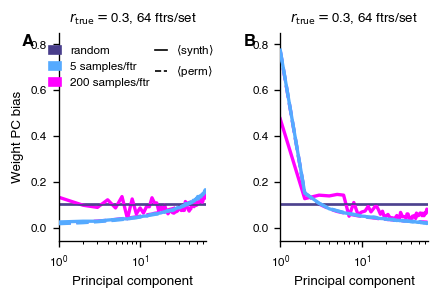

In [29]:
def hook_weight_pc_cossim_legend(plot, element):
    
    ax = plot.handles['axis']
    
    patch_rnd = mpatches.Patch(color=clr_random, label='random')
    patch_2 = mpatches.Patch(color=n_per_ftr_clrs[1], label='{} samples/ftr'.format(n_per_ftr_typical))
    patch_50 = mpatches.Patch(color=n_per_ftr_clrs[-1], label='200 samples/ftr')
    line_synt = Line2D([0], [0], color='black', linewidth=1, linestyle='-', label=r'$\langle$synth$\rangle$')
    line_null = Line2D([0], [0], color='black', linewidth=1, linestyle='--', label=r'$\langle$perm$\rangle$')
    
    ax.legend(handles=[patch_rnd, patch_2, patch_50, line_synt, line_null], frameon=False, fontsize=7, 
              handlelength=1, ncol=2, columnspacing=.5, 
              loc='upper right', bbox_to_anchor=(1.125, 1.0))
    
    
panels_cca_weight_pc_cossim = (
    plot_weight_pc_cossim(res['cca'].sel(r=0.3, n_per_ftr=200), color=n_per_ftr_clrs[-1])
    * plot_weight_pc_cossim(res['cca'].sel(r=0.3, n_per_ftr=n_per_ftr_typical), color=n_per_ftr_clrs[1])
).relabel(
    r'$r_\mathrm{true}=$0.3, 64 ftrs/set'
).opts(
    logx=True, logy=False, show_legend=True,
    hooks=[hook_weight_pc_cossim_legend, 
    #Ax_ticks('y', [.1, .5], [r'$\mathregular{10^{-1}}$', r'$\mathregular{5\times 10^{-1}}$'])
    ]
)


panels_pls_weight_pc_cossim = (
    plot_weight_pc_cossim(res['pls'].sel(r=0.3, n_per_ftr=200), color=n_per_ftr_clrs[-1])
    * plot_weight_pc_cossim(res['pls'].sel(r=0.3, n_per_ftr=n_per_ftr_typical), color=n_per_ftr_clrs[1])
).relabel(
    r'$r_\mathrm{true}=$0.3, 64 ftrs/set'
).opts(
    show_legend=False, logx=True, logy=False, ylabel='',
    #hooks=[Ax_ticks('y', [.1, .5], [r'$\mathregular{10^{-1}}$', r'$\mathregular{5\times 10^{-1}}$'])]
)


(
    panels_cca_weight_pc_cossim
    + panels_pls_weight_pc_cossim
).opts(*fig_opts)

## How strong is the PC bias depending on sample size and true between-set correlation?

We define "PC bias" as the mean cosine-similarity between estimated weights and the 1st principal component axis. The mean is taken across repetitions, dimensionalities and different instantiations of the joint covariance matrix.

:Layout
   .Overlay.I  :Overlay
      .Curve.R_reverse_over_mathrm_left_curly_bracket_true_right_curly_bracket_equals_0_full_stop_1.I  :Curve   [Samples per feature]   (cossim_weights_1stPCaxis)
      .Curve.R_reverse_over_mathrm_left_curly_bracket_true_right_curly_bracket_equals_0_full_stop_3.I  :Curve   [Samples per feature]   (cossim_weights_1stPCaxis)
      .Curve.R_reverse_over_mathrm_left_curly_bracket_true_right_curly_bracket_equals_0_full_stop_5.I  :Curve   [Samples per feature]   (cossim_weights_1stPCaxis)
      .Curve.R_reverse_over_mathrm_left_curly_bracket_true_right_curly_bracket_equals_0_full_stop_1.II :Curve   [Samples per feature]   (cossim_weights_1stPCaxis)
      .Curve.R_reverse_over_mathrm_left_curly_bracket_true_right_curly_bracket_equals_0_full_stop_3.II :Curve   [Samples per feature]   (cossim_weights_1stPCaxis)
      .Curve.R_reverse_over_mathrm_left_curly_bracket_true_right_curly_bracket_equals_0_full_stop_5.II :Curve   [Samples per feature]   (cossim_weights_1stPCaxis)
      .Text.I                                                                                          :Text   [x,cossim_weights_1stPCaxis]
      .Text.II                                                                                         :Text   [x,cossim_weights_1stPCaxis]
      .Text.III                                                                                        :Text   [x,cossim_weights_1stPCaxis]
      .Text.IV                                                                                         :Text   [x,cossim_weights_1stPCaxis]
   .Overlay.II :Overlay
      .Curve.R_reverse_over_mathrm_left_curly_bracket_true_right_curly_bracket_equals_0_full_stop_1.I  :Curve   [Samples per feature]   (cossim_weights_1stPCaxis)
      .Curve.R_reverse_over_mathrm_left_curly_bracket_true_right_curly_bracket_equals_0_full_stop_3.I  :Curve   [Samples per feature]   (cossim_weights_1stPCaxis)
      .Curve.R_reverse_over_mathrm_left_curly_bracket_true_right_curly_bracket_equals_0_full_stop_5.I  :Curve   [Samples per feature]   (cossim_weights_1stPCaxis)
      .Curve.R_reverse_over_mathrm_left_curly_bracket_true_right_curly_bracket_equals_0_full_stop_1.II :Curve   [Samples per feature]   (cossim_weights_1stPCaxis)
      .Curve.R_reverse_over_mathrm_left_curly_bracket_true_right_curly_bracket_equals_0_full_stop_3.II :Curve   [Samples per feature]   (cossim_weights_1stPCaxis)
      .Curve.R_reverse_over_mathrm_left_curly_bracket_true_right_curly_bracket_equals_0_full_stop_5.II :Curve   [Samples per feature]   (cossim_weights_1stPCaxis)
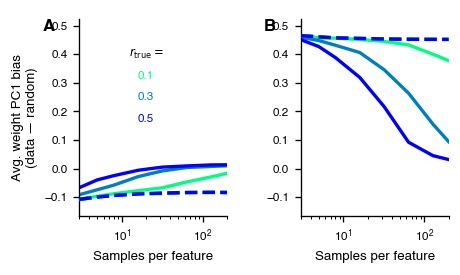

In [30]:
panels_nPerFtrs_cossim = {model: hv.Overlay() for model in res}

for model in res:
    
    mean_beta_rvs = xr.DataArray(pd.Series(
        {px: np.abs(scipy.stats.beta.rvs((px-1)/2, (px-1)/2, size=(10000)) * 2 - 1).mean() 
         for px in res[model].px.values},
    )).rename(dim_0='px')
        
    delta_pc1bias = np.maximum(
        (np.abs(res[model].x_weights_pc_cossim.sel(x_feature=0)) - mean_beta_rvs).mean('rep').mean('Sigma_id').mean('px'),
        (np.abs(res[model].y_weights_pc_cossim.sel(y_feature=0)) - mean_beta_rvs).mean('rep').mean('Sigma_id').mean('px')
    )
    
    delta_pc1bias_perm = np.maximum(
        (np.abs(res[model].x_weights_pc_cossim_perm.sel(x_feature=0)) - mean_beta_rvs).mean('rep').mean('Sigma_id').mean('perm').mean('px'),
        (np.abs(res[model].y_weights_pc_cossim_perm.sel(y_feature=0)) - mean_beta_rvs).mean('rep').mean('Sigma_id').mean('perm').mean('px')
    )

    for r in delta_pc1bias.r.values:
        panels_nPerFtrs_cossim[model] *= hv.Curve(delta_pc1bias.sel(r=r), label=r'$r_\mathrm{true}=%.1f$' % r)
        
    for r in delta_pc1bias_perm.r.values:
        panels_nPerFtrs_cossim[model] *= hv.Curve(delta_pc1bias_perm.sel(r=r), label=r'$r_\mathrm{true}=%.1f$' % r).opts(linestyle='--')
        
fig_nPerFtrs_cossim = (
    (
        panels_nPerFtrs_cossim['cca']
        * hv.Text(20, .4, r'$r_\mathrm{true}=$', fontsize=7, halign='center')
        * hv.Text(20, .325, '0.1', fontsize=7, halign='center').opts(color=r_clrs[0])
        * hv.Text(20, .25, '0.3', fontsize=7, halign='center').opts(color=r_clrs[1])
        * hv.Text(20, .175, '0.5', fontsize=7, halign='center').opts(color=r_clrs[2])
    ).opts(show_legend=False)
    + panels_nPerFtrs_cossim['pls'].opts(show_legend=False, ylabel='')
).redim(
    n_per_ftr='Samples per feature',
    y=hv.Dimension('cossim_weights_1stPCaxis', label='Avg. weight PC1 bias\n(data — random)')
).opts(*fig_opts).opts(
    opts.Curve(color=hv.Cycle(r_clrs)),
    opts.Overlay(logx=True)
)

fig_nPerFtrs_cossim

## Assemble figure

In [31]:
px = 100

In [32]:
# holoviews hooks

def set_axis_position(plot, element):
    ax = plot.handles['axis']
    bbox = ax.get_position()
    
    if bbox.x0 < .1:
        x0 = .05
    elif bbox.x0 < .35:
        x0 = .26
    elif bbox.x0 < .6:
        x0 = .55
    else:
        x0 = .77
        
    if bbox.y0 < .1:
        y0 = .05
    elif bbox.y0 < .5:
        y0 = .05 + .3
    else:
        y0 = .05 + .6
        
    ax.set_position((x0, y0, .14, .2))
    

def legend_samples_per_feature(plot, element):
    ax = plot.handles['axis']
    fontdict=dict(size=8)
    text = ax.text(1.05, .775, '5', ha='left', color=n_per_ftr_clrs[1], transform=ax.transAxes, fontdict=fontdict)
    ax.text(1.25, .775, '50', ha='right', color=n_per_ftr_clrs[2], transform=ax.transAxes, fontdict=fontdict)
    ax.text(1.15, .9, 'smpls/ftr', ha='center', transform=ax.transAxes, fontdict=fontdict)
    # make '5' more visible
    # text.set_path_effects([
    #     path_effects.Stroke(linewidth=.1, foreground='black'),
    #     path_effects.Normal()
    # ])
    
    
def axpos_middlerow(plot, element):
    return
    ax = plot.handles['axis']
    bbox = ax.get_position()
    ax.set_position((bbox.x0, bbox.y0+.025, bbox.width, bbox.height))
    
    
def axpos_bottomrow(plot, element):
    return
    ax = plot.handles['axis']
    bbox = ax.get_position()
    ax.set_position((bbox.x0+.025, .05, .85*bbox.width, .9*bbox.height))
    
    
def synth_perm_legend(plot, element):
    
    ax = plot.handles['axis']
    
    line_synt = Line2D([0], [0], color='black', linewidth=1, linestyle='-', label=r'synth')
    line_null = Line2D([0], [0], color='black', linewidth=1, linestyle='--', label=r'perm')
    
    ax.legend(handles=[line_synt, line_null], frameon=False, fontsize=7, 
              handlelength=1, ncol=1,
              loc='upper right', bbox_to_anchor=(1., 1.03))

:Layout
   .Overlay.R_reverse_over_mathrm_left_curly_bracket_true_right_curly_bracket_equals_0_full_stop_3_comma_100_ftrs_over_set.I  :Overlay
      .Area.N_reverse_over_mathrm_left_curly_bracket_typical_right_curly_bracket                      :Area   [Feature id]   (Weight,y2)
      .Area.10_reverse_over_cdot_n_reverse_over_mathrm_left_curly_bracket_typical_right_curly_bracket :Area   [Feature id]   (Weight,y2)
      .Curve.True                                                                                     :Curve   [Feature id]   (Weight)
      .HLine.I                                                                                        :HLine   [Feature id,Weight]
      .Text.I                                                                                         :Text   [x,y]
   .Overlay.R_reverse_over_mathrm_left_curly_bracket_true_right_curly_bracket_equals_0_full_stop_3_comma_100_ftrs_over_set.II :Overlay
      .Area.N_reverse_over_mathrm_left_curly_bracket_typical_right_curly_bracket                      :Area   [Feature id]   (Weight,y2)
      .Area.10_reverse_over_cdot_n_reverse_over_mathrm_left_curly_bracket_typical_right_curly_bracket :Area   [Feature id]   (Weight,y2)
      .Curve.True                                                                                     :Curve   [Feature id]   (Weight)
      .HLine.I                                                                                        :HLine   [Feature id,Weight]
      .Text.I                                                                                         :Text   [x,y]
   .QuadMesh.Weight_error_reverse_over_leq_10_percent.I                                                                       :QuadMesh   [Number of features,$r_\mathrm{true}$]   (Required sample size)
   .QuadMesh.Weight_error_reverse_over_leq_10_percent.II                                                                      :QuadMesh   [Number of features,$r_\mathrm{true}$]   (Required sample size)
   .Overlay.I                                                                                                                 :Overlay
      .Curve.I        :Curve   [Samples per feature]   (Weight stability)
      .Curve.II       :Curve   [Samples per feature]   (Weight stability)
      .Curve.III      :Curve   [Samples per feature]   (Weight stability)
      .Curve.IV       :Curve   [Samples per feature]   (Weight stability)
      .Curve.V        :Curve   [Samples per feature]   (Weight stability)
      .Curve.VI       :Curve   [Samples per feature]   (Weight stability)
      .Curve.VII      :Curve   [Samples per feature]   (Weight stability)
      .Curve.VIII     :Curve   [Samples per feature]   (Weight stability)
      .Curve.IX       :Curve   [Samples per feature]   (Weight stability)
      .Curve.X        :Curve   [Samples per feature]   (Weight stability)
      .Curve.XI       :Curve   [Samples per feature]   (Weight stability)
      .Curve.XII      :Curve   [Samples per feature]   (Weight stability)
      .Curve.XIII     :Curve   [Samples per feature]   (Weight stability)
      .Curve.XIV      :Curve   [Samples per feature]   (Weight stability)
      .Curve.XV       :Curve   [Samples per feature]   (Weight stability)
      .Curve.XVI      :Curve   [Samples per feature]   (Weight stability)
      .Curve.XVII     :Curve   [Samples per feature]   (Weight stability)
      .Curve.XVIII    :Curve   [Samples per feature]   (Weight stability)
      .Curve.XIX      :Curve   [Samples per feature]   (Weight stability)
      .Curve.XX       :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXI      :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXII     :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXIII    :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXIV     :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXV      :Curve   [Samples per feature]   (Weight stability)
      .Curve.XXVI    
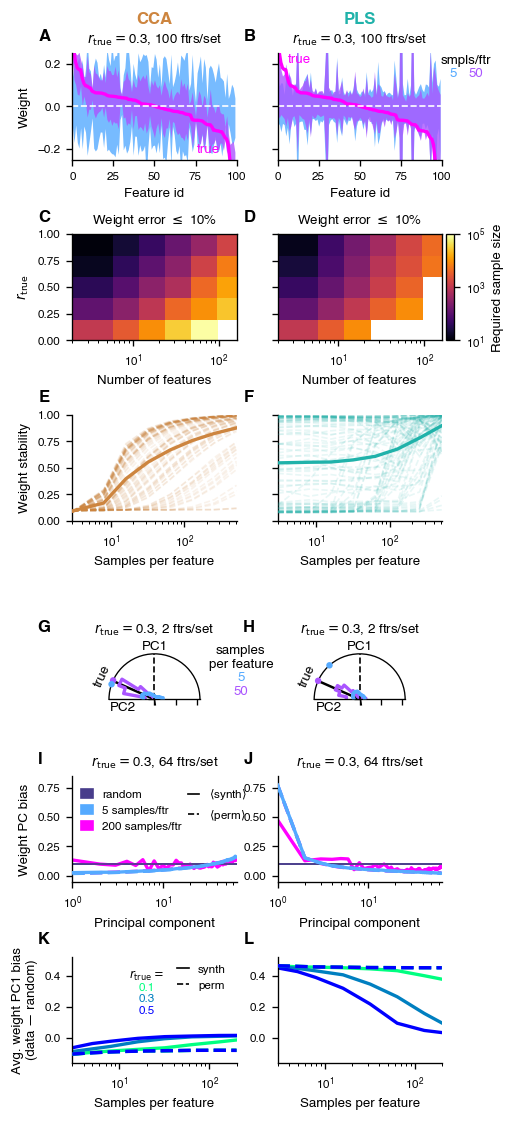

In [33]:
fig = (
    (
        panels_weights_100['cca']
        * hv.Text(90, -0.175, 'true', halign='right', valign='top', fontsize=8).opts(color=n_per_ftr_clrs[-1])
    ).relabel('$r_\mathrm{true}=$0.3, 100 ftrs/set').opts(
        xlim=(0, 100), ylim=(-.25, .25), hooks=[Suptitle('CCA', clr_cca, 1.25)]
    )
    + (
        panels_weights_100['pls']
        * hv.Text(6, 0.25, 'true', halign='left', valign='top', fontsize=8).opts(color=n_per_ftr_clrs[-1])
    ).relabel('$r_\mathrm{true}=$0.3, 100 ftrs/set').opts(
        xlim=(0, 100), ylim=(-.25, .25), yaxis='bare', hooks=[Suptitle('PLS', clr_pls, 1.25), legend_samples_per_feature]
    )
    # ---
    + heatmap_n_req(nPerFtr2n(cca_n_req_per_ftr['weightError'], ds_cca.py)).relabel('Weight error $\leq$ 10%')
    + heatmap_n_req(nPerFtr2n(pls_n_req_per_ftr['weightError'], ds_pls.py)).relabel('Weight error $\leq$ 10%').opts(
        colorbar=True, yaxis='bare', 
    )

    # ---
    + plot_cossim_weights_stats(res_cossim_weights['cca'].sel(px=100, r=0.3), outcome='x_weights_pairwise_cossim_stats', color=clr_cca).opts(
        logx=True, logy=False
    )
    + (
        plot_cossim_weights_stats(res_cossim_weights['pls'].sel(px=100, r=0.3), color=clr_pls)
    ).opts(ylim=(0, 1), yaxis='bare', logx=True, logy=False)
    # ---
    + fig_weights_2.opts(opts.Overlay(sublabel_position=(-.95, .8)))
    # ---
    + panels_cca_weight_pc_cossim.opts(hooks=[axpos_middlerow, hook_weight_pc_cossim_legend])
    + panels_pls_weight_pc_cossim.opts(hooks=[axpos_middlerow,])
    # ---
    + fig_nPerFtrs_cossim.Overlay.I.opts(opts.Overlay(hooks=[axpos_bottomrow, synth_perm_legend, legend_frame_off]))
    + fig_nPerFtrs_cossim.Overlay.II.opts(opts.Overlay(hooks=[axpos_bottomrow]))
).cols(
    2
).opts(*fig_opts).opts(*fig_opts).opts(
    opts.QuadMesh(logx=True, logz=True, ylim=(0, 1),
                  clim=(1e1, 1e5), cmap='inferno',
                  fontsize=dict(labels=8, ticks=7, legend=7, title=8),
                  aspect='auto'
                 ),
    opts.Overlay(aspect='auto'),
    #opts.Overlay(sublabel_position=(-.35, .95)),
    opts.Layout(hspace=.25, vspace=.7, fig_inches=(3.42, 8), sublabel_position=(-.3, .95))
)

hv.save(fig, 'fig/fig3_weights.pdf')

fig